In [99]:
import os,sys
import yt
import numpy as np
import pyxsim
import soxs
from yt import units as un, physical_constants as cons
sys.path.append('../pysrc/')

In [100]:
import projectPlotBasics

In [225]:
import pylab as pl
import matplotlib
from matplotlib import ticker
figdir = '/Users/jonathanstern/Dropbox/Apps/Overleaf/Analytic2D/'

In [3]:
Rcirc_sim = 10*un.kpc
os.system("rm /Users/jonathanstern/Downloads/*.ewah")
ds = yt.load("/Users/jonathanstern/Downloads/snapshot_324.hdf5")
ad = ds.all_data()
center = ad[ ('PartType5', 'Coordinates')][0]

yt : [INFO     ] 2022-12-16 12:26:03,046 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2022-12-16 12:26:03,047 Assuming length units are in kpc (physical)
yt : [INFO     ] 2022-12-16 12:26:03,100 Parameters: current_time              = 3.23999997228384
yt : [INFO     ] 2022-12-16 12:26:03,101 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-12-16 12:26:03,101 Parameters: domain_left_edge          = None
yt : [INFO     ] 2022-12-16 12:26:03,101 Parameters: domain_right_edge         = None
yt : [INFO     ] 2022-12-16 12:26:03,101 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2022-12-16 12:26:03,127 Allocating for 5.384e+06 particles
yt : [INFO     ] 2022-12-16 12:26:03,128 Bounding box cannot be inferred from metadata, reading particle positions to infer bounding box
yt : [INFO     ] 2022-12-16 12:26:03,391 Load this dataset with bounding_box=[[-3381.34106445 -3282.19042969 -3277.86499023], [3261.54125977 3412.69750977 3386.10791

In [4]:
#NGC891
d = 9.52*un.Mpc #Bregmann22
Rcirc = (13.18/2*un.arcminute).to('radian')*d.to('kpc') #Bregmann22
size_ratio = (Rcirc/Rcirc_sim).value #better run a sim with correct size

In [5]:
def _kSZ_integrand(field, data, coeff = cons.sigma_thompson/cons.c):
    return coeff * data["gas", "El_number_density"] * data["gas", "velocity_x"]
ds.add_field(
    name=("gas", "kSZ_integrand"),
    function=_kSZ_integrand,
    sampling_type="local",
    units="cm**-1",
)

In [6]:
# define hot gas filter
def hot_CGM(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5*un.K
    pfilter2 = data[pfilter.filtered_type, "radius"] < 200*un.kpc
    return pfilter1 & pfilter2
yt.add_particle_filter("hot_gas", function=hot_CGM, filtered_type='gas', requires=["temperature","radius"])
ds.add_particle_filter('hot_gas')

True

In [7]:
pixel_physical_size = (1*un.arcminute).to('radian')*d.to('kpc') #Battaglia+17
fld = "kSZ_integrand"
width_in_kpc = 150
Npixels = width_in_kpc // pixel_physical_size.value
plot = yt.ProjectionPlot(ds, 0, ("hot_gas", fld), center=center,method="integrate",
                        width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))
kSZ = plot.to_fits_data()[fld].data
X,Y = [np.linspace(-width_in_kpc//2,width_in_kpc//2,int(Npixels)) for _ in range(2)]

yt : [INFO     ] 2022-12-16 12:26:39,020 xlim = -41.086821 41.107683
yt : [INFO     ] 2022-12-16 12:26:39,021 ylim = -41.098065 41.096439
yt : [INFO     ] 2022-12-16 12:26:39,022 xlim = -41.086821 41.107683
yt : [INFO     ] 2022-12-16 12:26:39,022 ylim = -41.098065 41.096439
yt : [INFO     ] 2022-12-16 12:26:39,026 Making a fixed resolution buffer of (('hot_gas', 'kSZ_integrand')) 54 by 54
yt : [INFO     ] 2022-12-16 12:26:42,088 Making a FITS image of field kSZ_integrand


In [8]:
DT = kSZ*2.7 * 1e6
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))
DT_tuple = X,Y,DT * mask

In [152]:
emin_in_keV = 0.54
emax_in_keV = 0.59
nbins = 1000
Zmet = 0.3 # this dataset does not have a metallicity field, so assume 0.3 Zsolar
source_model = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)

pyxsim : [INFO     ] 2022-12-16 17:07:36,608 kT_min = 0.025 keV
pyxsim : [INFO     ] 2022-12-16 17:07:36,608 kT_max = 64.0 keV


# plot spectrum with thermal broadening only

In [153]:
sp = ds.sphere(center,200*un.kpc)
spec = source_model.make_spectrum(sp, emin_in_keV,emax_in_keV, nbins)

pyxsim : [INFO     ] 2022-12-16 17:07:37,114 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2022-12-16 17:07:37,117 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/2730682 [00:00<?, ?it/s]

Text(0.5, 0, 'energy [keV]')

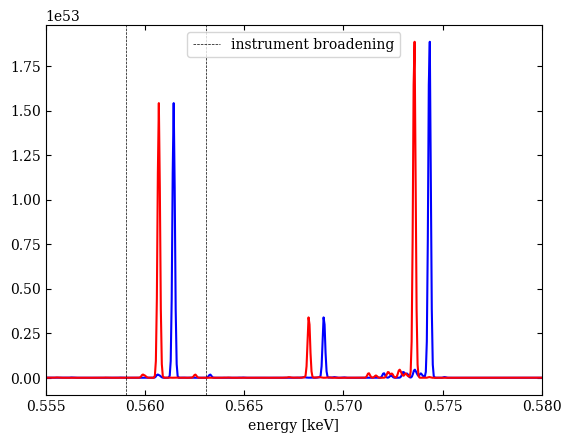

In [154]:
v_th = ((cons.kb*2e6*un.K/(16*cons.mp))**0.5).to('km/s')
v_phi = 200*un.km/un.s
v_inst = 0.002/0.56 * cons.c.to('km/s')

line_center = 0.561065*un.keV
for j in range(2):
    pl.plot(spec.emid*(1+(v_phi/cons.c).to(''))**((-1)**j),spec.flux,c='br'[j])
    pl.axvline(line_center.value*(1+(v_inst/cons.c).to(''))**((-1)**j),c='k',ls='--',lw=0.5,label=('instrument broadening','_')[j])
pl.xlim(0.555,0.58)
pl.legend()
pl.xlabel('energy [keV]')

In [13]:
#single line flux
emin_in_keV = 0.56
emax_in_keV = 0.563 
xray_fields = source_model.make_source_fields(ds, emin_in_keV, emax_in_keV)
xray_fields

pyxsim : [INFO     ] 2022-12-16 12:27:54,276 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2022-12-16 12:27:54,286 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.56_0.563_keV'),
 ('gas', 'xray_luminosity_0.56_0.563_keV'),
 ('gas', 'xray_photon_emissivity_0.56_0.563_keV')]

In [50]:
#LEM
d=40*un.Mpc
pixel_angular_size  = 15*un.arcsecond
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #LEM paper
FOV_in_pixels = 118
img_width_physical = pixel_physical_size*FOV_in_pixels
img_Npixels = FOV_in_pixels
pixel_area = (img_width_physical/img_Npixels)**2
A_LEM = 1600*un.cm**2
geometric_dilution = (A_LEM / (4*np.pi*d**2)).to('')


In [51]:
Npixels_to_sum = 1 #in one dimension
fld = 'xray_emissivity_0.56_0.563_keV'
X,Y = [np.linspace(-img_width_physical//2,img_width_physical//2,int(img_Npixels)) for _ in range(2)]
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))

In [52]:
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission = plot.to_fits_data()[fld].data 
cnts = (emission * pixel_area * geometric_dilution  / line_center / (2.35*v_inst/cons.c*line_center)).to('s**-1*keV**-1')

yt : [INFO     ] 2022-12-16 15:51:48,466 xlim = -94.033256 94.054118
yt : [INFO     ] 2022-12-16 15:51:48,473 ylim = -94.044501 94.042874
yt : [INFO     ] 2022-12-16 15:51:48,474 xlim = -94.033256 94.054118
yt : [INFO     ] 2022-12-16 15:51:48,475 ylim = -94.044501 94.042874
yt : [INFO     ] 2022-12-16 15:51:48,477 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 118 by 118
yt : [INFO     ] 2022-12-16 15:51:52,147 Making a FITS image of field xray_emissivity_0.56_0.563_keV


/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_40297/2437631085.py:3: UserWarning: The following kwargs were not used by contour: 'c'
  pl.contour(X,Y,cnts,[0.02],c='k') #background


Text(0, 0.5, '$z\\ [{\\rm kpc}]$')

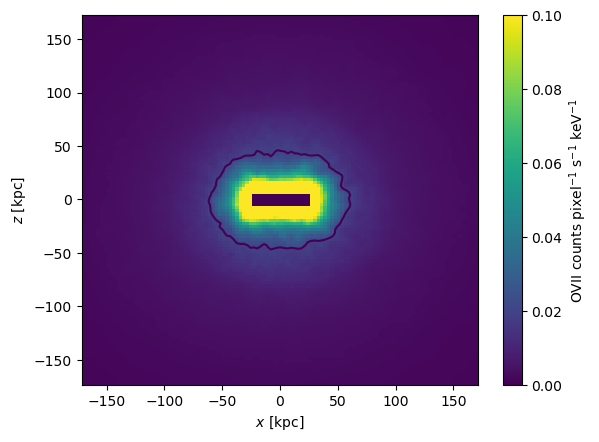

In [53]:
pl.pcolormesh(X,Y,cnts*mask,cmap='viridis',vmax=0.1)
pl.colorbar(label=r'OVII counts ${\rm pixel}^{-1}\ {\rm s}^{-1}\ {\rm keV}^{-1}$')
pl.contour(X,Y,cnts,[0.02],c='k') #background
pl.xlim(-img_width_physical/2,img_width_physical/2)
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.ylabel(r'$z\ [{\rm kpc}]$')

In [54]:
plot = yt.ProjectionPlot(ds, 0, ("gas","velocity_x"),weight_field=("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission_weighted_velocity = plot.to_fits_data()["velocity_x"].data.to('km/s')
emission_weighted_velocity_tuple = X,Y,emission_weighted_velocity*mask

yt : [INFO     ] 2022-12-16 15:51:52,316 xlim = -94.033256 94.054118
yt : [INFO     ] 2022-12-16 15:51:52,316 ylim = -94.044501 94.042874
yt : [INFO     ] 2022-12-16 15:51:52,317 xlim = -94.033256 94.054118
yt : [INFO     ] 2022-12-16 15:51:52,317 ylim = -94.044501 94.042874
yt : [INFO     ] 2022-12-16 15:51:52,318 Making a fixed resolution buffer of (('gas', 'velocity_x')) 118 by 118
yt : [INFO     ] 2022-12-16 15:51:55,969 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 118 by 118
yt : [INFO     ] 2022-12-16 15:51:59,594 Making a FITS image of field velocity_x


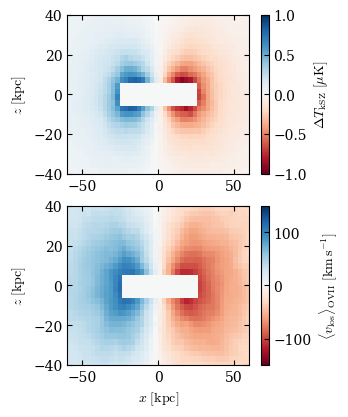

In [242]:
xrng = 60;
fig = pl.figure(figsize=(3.5,4.55))
gs  = matplotlib.gridspec.GridSpec(ncols=1, nrows=2)
pl.subplots_adjust(hspace=0.2,left=0.2,right=0.85,wspace=0.4)
for iobs in range(2):
    X,Y,vals = (DT_tuple,emission_weighted_velocity_tuple)[iobs]
    mid,ind = len(Y)//2,np.searchsorted(X,-26)
    label = (r'$\Delta T_{\rm kSZ}\ [\mu{\rm K}]$',r'$\langle v_{\rm los}\rangle_{\rm OVII}\ [{\rm km}\,{\rm s}^{-1}]$')[iobs]
    vrng=(1,150)[iobs]        
    ax = fig.add_subplot(gs[iobs,:2])
    pl.pcolormesh(X,Y,vals,cmap='RdBu',vmin=-vrng,vmax=vrng)
    pl.colorbar(label=label)
    pl.ylabel(r'$z\ [{\rm kpc}]$')
    pl.xlim(-xrng,xrng)
    pl.ylim(-2/3*xrng,2/3*xrng)
    if iobs==1: pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.savefig(figdir+'observed_velocity.png')

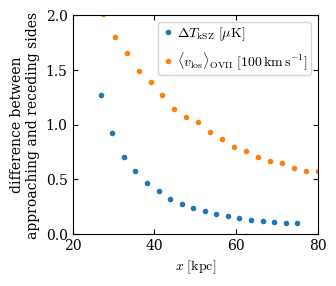

In [241]:
fig = pl.figure(figsize=(3.5,3)); ax = pl.subplot(111); pl.subplots_adjust(left=0.2,bottom=0.15)
for iobs in range(2):
    if iobs==0:
        X,Y,vals = DT_tuple
        label = r'$\Delta T_{\rm kSZ}\ [\mu{\rm K}]$'
        norm = 1
    else:
        X,Y,vals = emission_weighted_velocity_tuple
        label = r'$\langle v_{\rm los}\rangle_{\rm OVII}\ [100\, {\rm km}\,{\rm s}^{-1}]$'
        norm = 100
    mid,ind = len(Y)//2,np.searchsorted(X,-26)
    pl.plot(X[len(X)-ind:],(vals[mid,:ind][::-1]-vals[mid,len(X)-ind:])/norm,'.',label=label)
pl.xlim(20,80)
pl.ylabel('difference between\napproaching and receding sides')
pl.ylim(0,2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.legend(handletextpad=0.1,borderpad=0.25,handlelength=1)
pl.savefig(figdir+'observed_velocity_difference.pdf')

In [236]:
pl.legend?

In [110]:
#single line flux
emin_in_keV = 0.5
emax_in_keV = 2
xray_fields = source_model.make_source_fields(ds, emin_in_keV, emax_in_keV)
xray_fields

pyxsim : [INFO     ] 2022-12-16 16:46:31,363 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2022-12-16 16:46:31,366 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.5_2_keV'),
 ('gas', 'xray_luminosity_0.5_2_keV'),
 ('gas', 'xray_photon_emissivity_0.5_2_keV')]

In [131]:
#LEM
d=40*un.Mpc
pixel_angular_size  = 1*un.arcsecond
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #LEM paper
FOV_in_pixels = 2000
img_width_physical = pixel_physical_size*FOV_in_pixels
img_Npixels = FOV_in_pixels
pixel_area = (img_width_physical/img_Npixels)**2
A_LEM = 1600*un.cm**2
geometric_dilution = (A_LEM / (4*np.pi*d**2)).to('')


In [132]:
Npixels_to_sum = 1 #in one dimension
fld = 'xray_photon_emissivity_0.5_2_keV'
X,Y = [np.linspace(-img_width_physical//2,img_width_physical//2,int(img_Npixels)) for _ in range(2)]
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))

In [133]:
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission = plot.to_fits_data()[fld].data 
cnts = (emission * pixel_area * geometric_dilution).to('s**-1')

yt : [INFO     ] 2022-12-16 17:01:02,464 xlim = -53.121596 53.142458
yt : [INFO     ] 2022-12-16 17:01:02,467 ylim = -53.132840 53.131213
yt : [INFO     ] 2022-12-16 17:01:02,469 xlim = -53.121596 53.142458
yt : [INFO     ] 2022-12-16 17:01:02,470 ylim = -53.132840 53.131213
yt : [INFO     ] 2022-12-16 17:01:02,472 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_2_keV')) 1000 by 1000
yt : [INFO     ] 2022-12-16 17:01:18,894 Making a FITS image of field xray_photon_emissivity_0.5_2_keV


In [177]:
#single line flux
nbins = 1000
Zmet = 0.3 # this dataset does not have a metallicity field, so assume 0.3 Zsolar
emin_in_keV = 0.56
emax_in_keV = 0.563 
source_model1 = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)
xray_fields1= source_model1.make_source_fields(ds, emin_in_keV, emax_in_keV,force_override=True)
emin_in_keV = 0.64
emax_in_keV = 0.68 
source_model2 = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)
xray_fields2= source_model2.make_source_fields(ds, emin_in_keV, emax_in_keV,force_override=True)


pyxsim : [INFO     ] 2022-12-16 17:16:32,586 kT_min = 0.025 keV
pyxsim : [INFO     ] 2022-12-16 17:16:32,586 kT_max = 64.0 keV
pyxsim : [INFO     ] 2022-12-16 17:16:32,607 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2022-12-16 17:16:32,608 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2022-12-16 17:16:34,126 kT_min = 0.025 keV
pyxsim : [INFO     ] 2022-12-16 17:16:34,127 kT_max = 64.0 keV
pyxsim : [INFO     ] 2022-12-16 17:16:34,147 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2022-12-16 17:16:34,148 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

In [178]:
plot = yt.ProjectionPlot(ds, 0, xray_fields1[0], center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
LOVII_emission = plot.to_fits_data()[xray_fields1[0][1]].data 

yt : [INFO     ] 2022-12-16 17:16:37,736 xlim = -53.121596 53.142458
yt : [INFO     ] 2022-12-16 17:16:37,739 ylim = -53.132840 53.131213
yt : [INFO     ] 2022-12-16 17:16:37,741 xlim = -53.121596 53.142458
yt : [INFO     ] 2022-12-16 17:16:37,743 ylim = -53.132840 53.131213
yt : [INFO     ] 2022-12-16 17:16:37,745 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 1000 by 1000
yt : [INFO     ] 2022-12-16 17:16:54,207 Making a FITS image of field xray_emissivity_0.56_0.563_keV


In [179]:
plot = yt.ProjectionPlot(ds, 0, xray_fields2[0], center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
LOVIII_emission = plot.to_fits_data()[xray_fields2[0][1]].data 

yt : [INFO     ] 2022-12-16 17:16:54,219 xlim = -53.121596 53.142458
yt : [INFO     ] 2022-12-16 17:16:54,220 ylim = -53.132840 53.131213
yt : [INFO     ] 2022-12-16 17:16:54,221 xlim = -53.121596 53.142458
yt : [INFO     ] 2022-12-16 17:16:54,221 ylim = -53.132840 53.131213
yt : [INFO     ] 2022-12-16 17:16:54,222 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.64_0.68_keV')) 1000 by 1000
yt : [INFO     ] 2022-12-16 17:17:10,750 Making a FITS image of field xray_emissivity_0.64_0.68_keV


In [180]:
ratio = LOVIII_emission/LOVII_emission

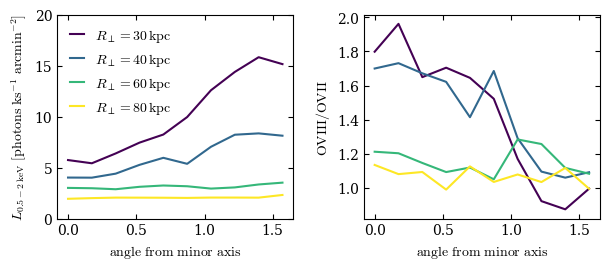

In [198]:
fig = pl.figure(figsize=(7,3.))
pl.subplots_adjust(wspace=0.3,bottom=0.2)
rs = np.array([30,40,60,80])
thetas=np.linspace(0,np.pi/2,10)
for iPanel in range(2):
    ax = pl.subplot(1,2,iPanel+1)
    for ir,r in enumerate(rs):
        c = pl.get_cmap('viridis')(ir/(len(rs)-1))
        iX = np.searchsorted(X,r*np.sin(thetas))
        iY = np.searchsorted(Y,r*np.cos(thetas))
        if iPanel==0:
            pl.plot(thetas, cnts[iY,iX]*3600e3,label=r'$R_\perp=%d\,{\rm kpc}$'%r,c=c)
        if iPanel==1:
            pl.plot(thetas, ratio[iY,iX],label=r'$R_\perp=%d\,{\rm kpc}$'%r,c=c)
    if iPanel==0:
        pl.ylabel(r'$L_{0.5-2\,{\rm keV}}\ [{\rm photons}\ {\rm ks}^{-1}\ {\rm arcmin}^{-2}]$')
        pl.legend(frameon=False,handlelength=1)
        pl.ylim(0,20)
    if iPanel==1:            
        pl.ylabel(r'${\rm OVIII}/{\rm OVII}$')
    pl.xlabel(r'${\rm angle\ from\ minor\ axis}$')
pl.savefig(figdir+'theta_dependence_observed.pdf')


In [269]:
2.3*1600*1.1**3*1.5**-1.5*0.5**-0.5 * 2.3

8672.250606637788

In [270]:
0.8e-3*2e6*5**0.5*0.3**-0.5*2.3

15023.53708907016

In [261]:
1800*2.3

4140.0

In [ ]:
1e59*un.erg/un.s/

In [260]:
((2*un.msun/un.yr*3000*un.km/un.s)/(cons.kb*2*np.pi*(15*un.kpc)**2)).to('cm**-3*K')

unyt_quantity(8844.63610135, 'K/cm**3')

In [254]:
1844/2211

0.8340117593848937

In [255]:
-0.5 * 1/0.29 + 1.1*0.5 + 3 +0.5

2.325862068965517

In [259]:
(0.1*4e6*un.Msun*cons.c**2/(10*un.Gyr)) / (1*un.Msun/un.yr*(220*un.km/un.s)**2)

unyt_quantity(74.2772875, '(dimensionless)')

In [243]:
sun_offset = ds.arr([0.,0., 0.], "kpc")
ray_length = 200*un.kpc
start_loc = center+sun_offset
bs = np.linspace(np.pi/6,np.pi/2,10)
ls = np.linspace(0,np.pi,5)
DM = {}
for l in ls:
    DM[l] = np.zeros(bs.shape)
    for ib,b in enumerate(bs):
        phi,theta = l, np.pi/2-b
        unit_vector = ds.arr([np.cos(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        my_ray = ds.ray(start_loc,end_loc)
        print(l,b,my_ray["dts"].sum())
        DM[l][ib] = (my_ray[("gas","El_number_density")] * my_ray["dts"] * (my_ray[("gas","temperature")]>1e6*un.K)).sum()*ray_length

0.0 0.5235987755982988 0.31740749685568026 dimensionless
0.0 0.6399540590645875 0.31491610985695073 dimensionless
0.0 0.7563093425308761 0.3198018173753374 dimensionless
0.0 0.8726646259971648 0.32136506941671483 dimensionless
0.0 0.9890199094634534 0.31640501676517785 dimensionless
0.0 1.105375192929742 0.32278795800251453 dimensionless
0.0 1.2217304763960306 0.32049600651220894 dimensionless
0.0 1.3380857598623193 0.3204503811460323 dimensionless
0.0 1.454441043328608 0.318817656281147 dimensionless
0.0 1.5707963267948966 0.3178967836359615 dimensionless
0.7853981633974483 0.5235987755982988 0.31012971356611474 dimensionless
0.7853981633974483 0.6399540590645875 0.3185904859571145 dimensionless
0.7853981633974483 0.7563093425308761 0.3064900292776442 dimensionless
0.7853981633974483 0.8726646259971648 0.2998577321838529 dimensionless
0.7853981633974483 0.9890199094634534 0.33479357232550244 dimensionless
0.7853981633974483 1.105375192929742 0.33384660081072065 dimensionless
0.7853981

In [ ]:
exp_time = (300., "ks") # exposure time
area = (1600.0, "cm**2") # collecting area
redshift = 0.002

In [221]:
res = (15*un.arcsecond).to('radian')*d.to('kpc') #LEM paper
size_ratio = (Rcirc/Rcirc_sim).value #better run a sim with correct size
fld = "velocity_x"
width_in_kpc = 100
Npixels = width_in_kpc // res.value
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                         weight_field=xray_fields[0],
                        width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))
projected = plot.to_fits_data()[fld].data
X,Y = [np.linspace(-width_in_kpc//2,width_in_kpc//2,int(Npixels)) for _ in range(2)]
#plot.set_unit(("hot_gas", "velocity_x"), "km/s")
#plot.save()

yt : [INFO     ] 2022-12-13 15:36:10,777 xlim = -27.387737 27.408599
yt : [INFO     ] 2022-12-13 15:36:10,778 ylim = -27.398981 27.397355
yt : [INFO     ] 2022-12-13 15:36:10,781 xlim = -27.387737 27.408599
yt : [INFO     ] 2022-12-13 15:36:10,782 ylim = -27.398981 27.397355
yt : [INFO     ] 2022-12-13 15:36:10,783 Making a fixed resolution buffer of (('gas', 'velocity_x')) 144 by 144
yt : [INFO     ] 2022-12-13 15:36:13,222 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 144 by 144
yt : [INFO     ] 2022-12-13 15:36:15,606 Making a FITS image of field velocity_x


In [170]:
prj = yt.ProjectionPlot(ds, "z", xray_fields[-1], width=(0.5, "Mpc"))
prj.save()

yt : [INFO     ] 2022-12-13 15:03:36,608 xlim = -312.894897 187.105103
yt : [INFO     ] 2022-12-13 15:03:36,610 ylim = -181.483783 318.516217
yt : [INFO     ] 2022-12-13 15:03:36,611 xlim = -312.894897 187.105103
yt : [INFO     ] 2022-12-13 15:03:36,612 ylim = -181.483783 318.516217
yt : [INFO     ] 2022-12-13 15:03:36,613 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_7.0_keV')) 800 by 800
yt : [INFO     ] 2022-12-13 15:03:44,987 Saving plot snapshot_324_Projection_z_xray_photon_emissivity_0.5_7.0_keV.png


['snapshot_324_Projection_z_xray_photon_emissivity_0.5_7.0_keV.png']

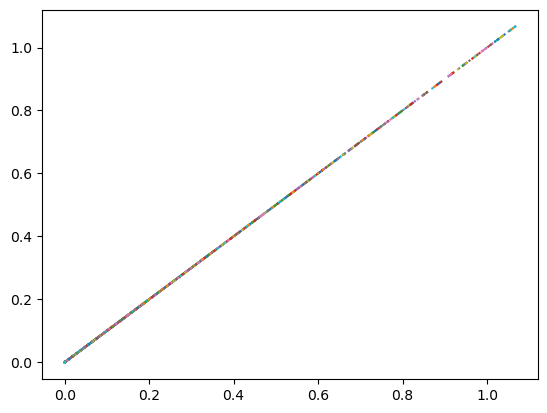

In [149]:
for i in range(len(my_ray["t"])):
    pl.plot([my_ray["t"][i],my_ray["t"][i]+my_ray["dts"][i]],[my_ray["t"][i],my_ray["t"][i]+my_ray["dts"][i]])
#%pl.semilogy()

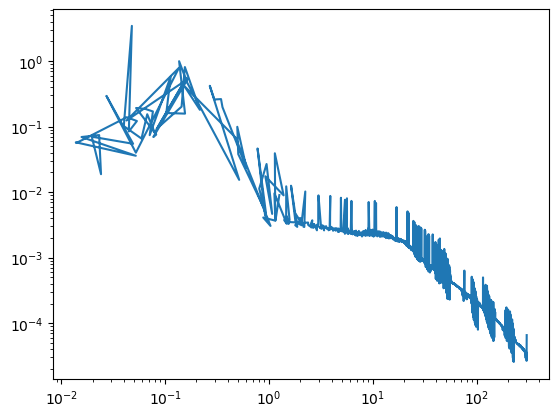

In [166]:
inds = my_ray["t"].argsort()
pl.loglog(my_ray["PartType0","BH_Dist"][inds],my_ray["gas","El_number_density"][inds])

In [156]:
l,b

(3.141592653589793, 1.5707963267948966)

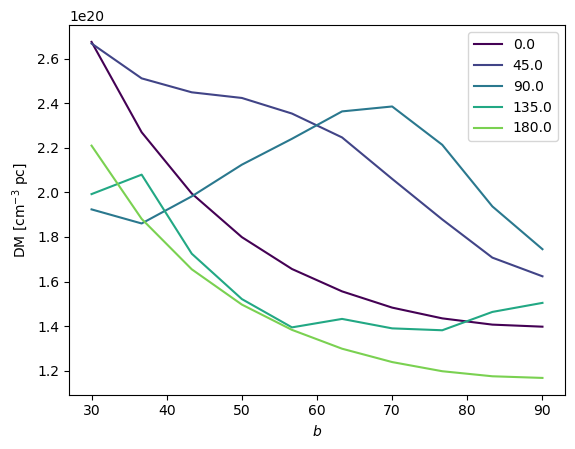

In [165]:
for il,l in enumerate(ls):
    pl.plot(bs/np.pi*180,DM[l],label=l/np.pi*180,c=pl.get_cmap('viridis')(il/len(ls)))
pl.xlabel(r'$b$')
pl.ylabel(r'${\rm DM}\ [{\rm cm}^{-3}\ {\rm pc}]$')
pl.legend()

In [88]:
plot = yt.SlicePlot(ds, "r", ("hot_gas", "El_number_density"), center=center,method="integrate")
                        #width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))


ValueError: 'r' is not a valid axis name. Expected one of 'x', 'y', 'z'.

In [ ]:
c_obs = c + ds.arr([8.,0., 0.], "code_length")
c_obs = ds.arr([8.,0., 0.], "code_length")
metals = ["He_fraction", "C_fraction", "N_fraction", "O_fraction",
          "Ne_fraction", "Mg_fraction", "Si_fraction", "Fe_fraction"]
var_elem = {elem.split("_")[0]: ("hot_gas", elem) for elem in metals}

# set up the source model

emin = 0.25 # The minimum energy to generate in keV
emax = 1.5 # The maximum energy to generate in keV
nbins = 5000 # The number of energy bins between emin and emax
kT_max = 2.0 # The max gas temperature to use
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","metallicity"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
    kT_max=kT_max, var_elem=var_elem
)
exp_time = (50., "s") # exposure time
area = (5000.0, "cm**2") # collecting area
redshift = 0.0 # the cosmological redshift of the source, this source is local
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)
c = ds.arr([0,0,0], "code_length")
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=bulk_velocity,
                                         observer="internal")
v = ds.arr([0,0,0], "km/s")
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=v,
                                         observer="internal")
ds.fields
sp
dir(ds)
ds.field_list
 pyxsim.CIESourceModel?
metals = ["He_fraction", "C_fraction", "N_fraction", "O_fraction",
          "Ne_fraction", "Mg_fraction", "Si_fraction", "Fe_fraction"]
var_elem = {elem.split("_")[0]: ("hot_gas", elem) for elem in metals}

# set up the source model

emin = 0.25 # The minimum energy to generate in keV
emax = 1.5 # The maximum energy to generate in keV
nbins = 5000 # The number of energy bins between emin and emax
kT_max = 2.0 # The max gas temperature to use
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","Metallicity_00"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
    kT_max=kT_max)
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=v,
                                         observer="internal")
ds.field_list
ad['PartType0', 'Velocities']
ad['PartType0', 'Velocities'].shape
yt.ProjectionPlot(ds, normal, ("gas", "velocity"), weight_field=("gas", "density")).save()
ys.ProjectionPlot
yt.ProjectionPlot
yt.ProjectionPlot?
yt.ProjectionPlot(ds, 1, ("gas", "velocity"), weight_field=("gas", "density")).save()
%history
dir(ds)
ds.add_field?

ds.add_field(
    name=("PartType0", "velocity_x"),
    function=_velocity_x,
    sampling_type="local",
    units="km/s",
)
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
ds.sphere?
sp = ds.sphere(c, (100.0, "kpc"))
yt.ProjectionPlot(sp, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
sp.field_list
dir(sp)
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
yt.ProjectionPlot(sp.ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)
my_sphere = sp
plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)
def _r(field, data):
    return (data["PartType0","Coordinates"]**2).sum()**0.5
ds.add_field(
    name=("PartType0", "radius"),
    function=_r,
    sampling_type="local",
    units="kpc",
)
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
    
)
plot.save()
plot.set_unit(("PartType0", "radius"), "kpc")
plot.save()
ds.derived_field_list
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),
)
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),
).save()
yt.ProfilePlot?
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),ylog=False,
).save()
yt.ProfilePlot?
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),y_log=False,
).save()
plot.set_unit(("PartType0", "radius"), "kpc")
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),y_log=False,
).save()
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses"")).save()
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses")).save()
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses")).save()
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("PartType0", "masses")).save()
ds.derived_field_list
yt.ProjectionPlot(ds, 1, ("PartType0", "particle_velocity_y"), weight_field=("PartType0", "mass")).save()
yt.ProjectionPlot(sp.ds, 1, ("PartType0", "particle_velocity_y"), weight_field=("PartType0", "mass")).save()
yt.ProjectionPlot?
yt.ProjectionPlot?